### formülü bu     
#### alttakide log loss tahmin edilen olasılıklar ile gerçek değerler arasındaki farkı hesaplıyor
![alt text](pngs/3.png)
çalışma mantığıda bu:
genelde classificationda kullanılıyor olasılık tahminleri yaparak predict edilen değerin hangi kümede olduğuna karar verir
0 ile 1 aralığında sigmoid bir grafiği ve alabileceği değerleri vardır
bir eşik değer belirlenir(genelde 0.5) o eşik değerin altında tahmin olursa değerimiz 0 kümesine atanır mesela eşik değer olan 0.5 ten büyükse 1 kümesine atanır ama eşik değeri yükseltmek accuracy değerini azaltır onada dikkat
eşik değerün üzerindeyse 1 kümesine atanır
mesela kadınmı-erkekmi   spammı-değilmi     doğrumu-yanlışmı gibi sonuçlara ulaştırır
deep learningde özellikle neural networkdede son katmanda sigmoid aktivasyon fonksiyonu kullanılıyor ordada 0 ile 1 kararları veriyor

lojistik resreyon için kullanılan optimizasyon yani graident descentte bu log loss fonksiyonunu kısmi türev ile minimize etme ile yapılıyor

# ----------------------------------------------------------------------------------
## confusion matrix

![alt text](pngs/4.png)

gerçek sınıf ile bizim modelin tahmininde eğer true olana bizim modelde true diyorsa TP veya gerçekte False olana bizim modelde False demiş ise True negatif yani negatifi doğru bildik
accuracy f1 score recall precision bunlar modelin performansını ölçüyor

# örnek:
### 1000 tane kredi kartı işleminden 990 ı normal işlemken 10 taneside sahtekarlık olsun 
### modelde 5 sahtekarlık tespit ettik

![alt text](pngs/5.png)
yani sözün özü accuracy çıktısına her zaman güvenilmez hasta adama sen hasta değilsin dersin durumu daha kötüye gidebilir
false pozitif ten ve false negatiften korkmak gerekir

# -----------------------------------------------------------------------------------------------
### roc curve

![alt text](pngs/6.png)

burdaki y ekseni gerçek pozitifler    x eksenide yanlış pozitifler (1.derece sıkıntı)
perfect classifier sol üst köşeye(0,1 max başarı) yakın olan ve grafikte en çok alanı kaplayan eğri en iyi eğridir bu eğrilerede bizim belirlediğimiz threshold değeri ile ulaşırız

eğrinin integrali alınıp alanı bilinmek istenirse AUC = AREA UNDER CURVE metriği elde edilir buda zaten roc curve ün sayısal ifade edilmişi



# ---------------------------------------------------------------------------------------------

In [100]:
# lojistik regresyon ile diyabet hastalığı tahmini
# Değişkenler
# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz.
# BloodPressure: Kan basıncı.
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [101]:
# 1. Exploratory Data Analysis
# 2. Data Preprocessing
# 3. Model & Prediction
# 4. Model Evaluation
# 5. Model Validation: Holdout
# 6. Model Validation: 10-Fold Cross Validation
# 7. Prediction for A New Observation


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

df = pd.read_csv("datasets/diabetes.csv")


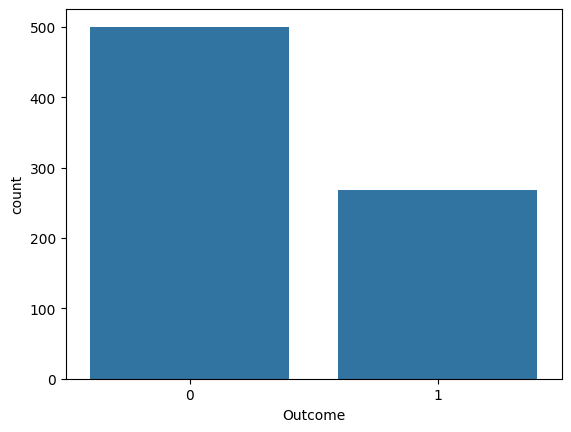

In [102]:
sns.countplot(x="Outcome", data=df)
plt.show() # 268 hasta 500 sağlıklı kişi var

In [103]:
100 * df["Outcome"].value_counts() / len(df)
# veya oranlarına bakalım

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

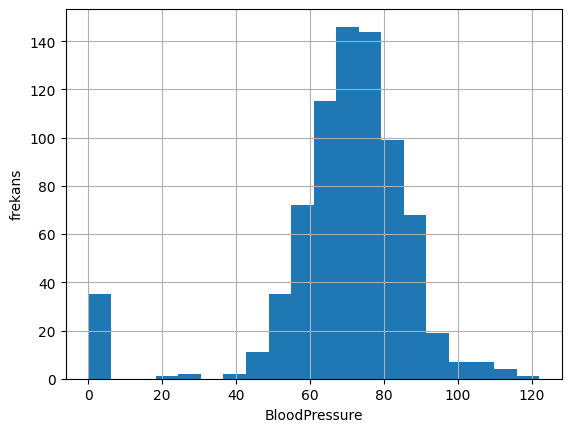

In [104]:
# sayısal değişkenleri görselleştirmek için 2 grafik türü akla gelmeli kutu ve histogram
# burada histogram kullanalım
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.ylabel("frekans")
plt.show()
# verisetinde kan basıncı 0 olan kişiler aslında eksik değerlerdi onları 0 girmişler

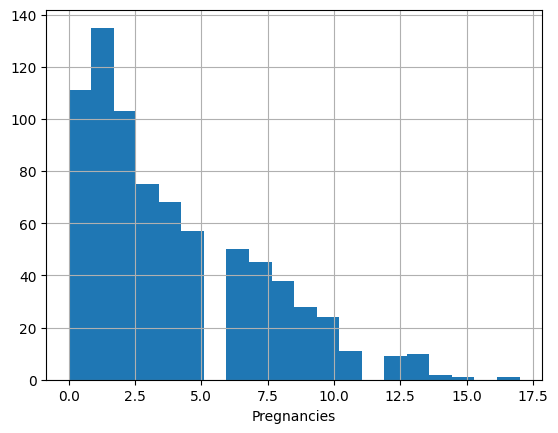

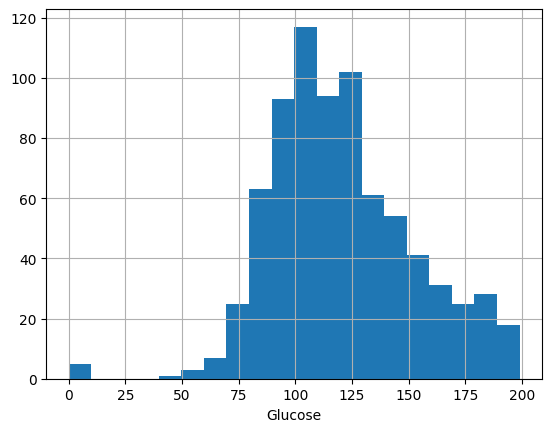

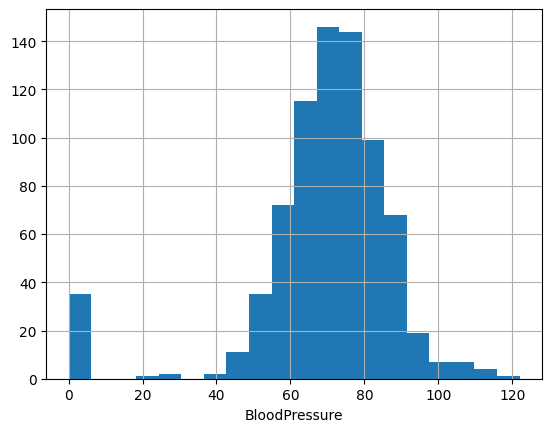

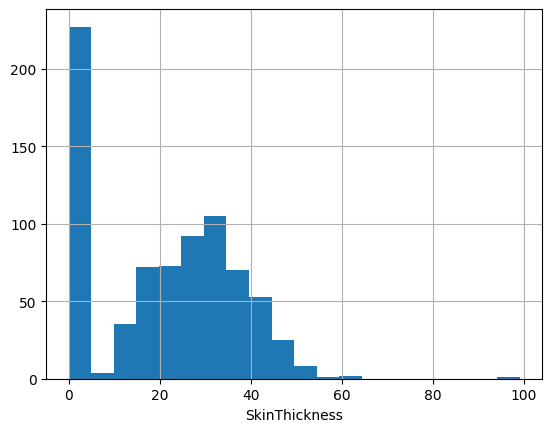

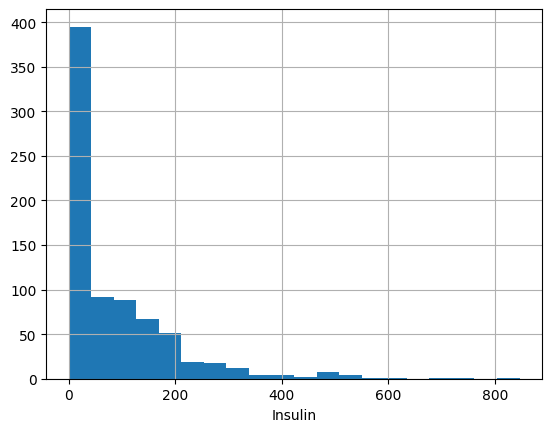

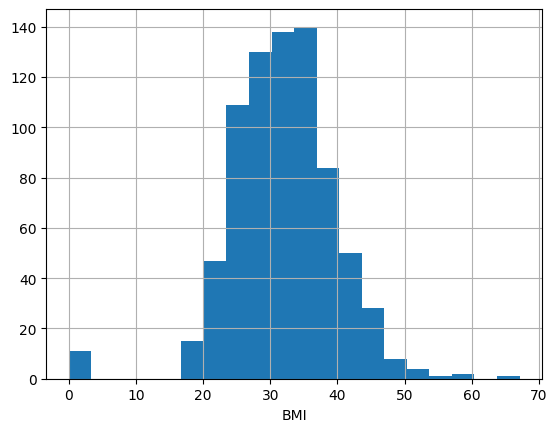

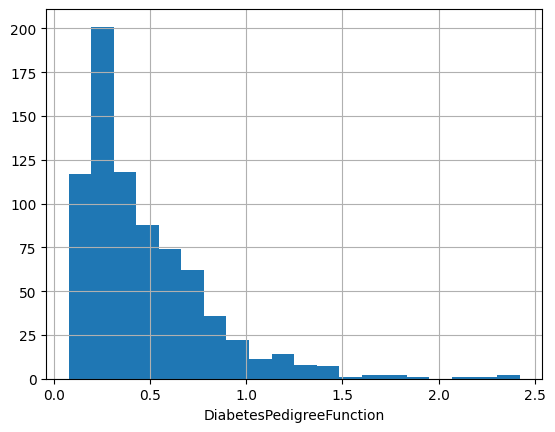

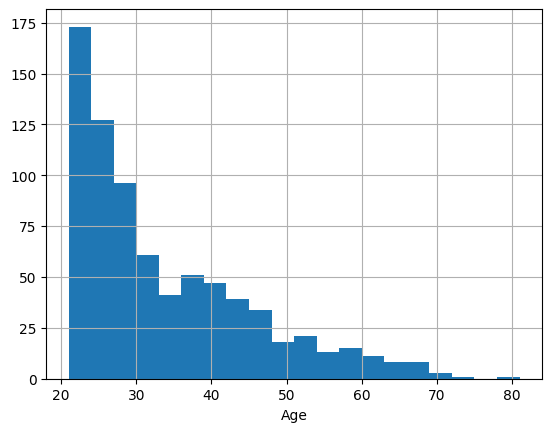

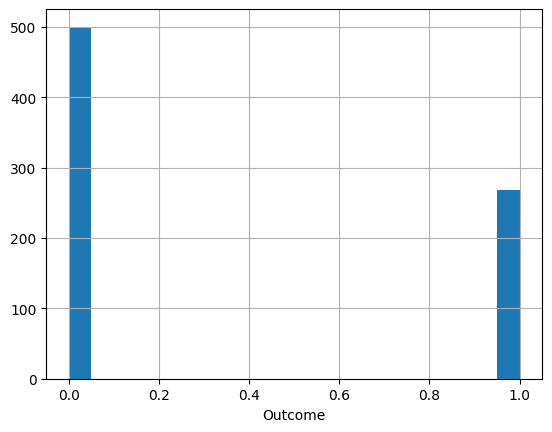

In [105]:
# ama tüm değişkenler için tek tek bakmayalım programatik yaklaşalım
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)


for col in df.columns:
    plot_numerical_col(df, col)

In [106]:
df.groupby("Outcome").agg({"Pregnancies": "mean"}) # mesela hamile olanları böyle inceledik kaçı diyabet kaçı değil gibisinden
# ama her seferinde aynı şeyleri yapmayalım


,Pregnancies
Outcome,
0,3.298
1,4.866


In [107]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in df.columns:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067


         Outcome
Outcome         
0          0.000
1          1.000




In [108]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [109]:
for col in df.columns:
    print(col, check_outlier(df, col)) # aykısı değer kontrolü
# sadece insülinde varmış

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [110]:
replace_with_thresholds(df, "Insulin") # şimdide insülindeki aykırılıkları belirlediğimiz eşik değerle değişelim

/tmp/ipykernel_1477251/756919936.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [111]:
# şimdide değişkenleri scale edelim
# doğrusal, gradyan, deep learning yöntemlerinde ölçeklendirme kullanılır
# standardize mesela A kan değeri 1000 li sayılar olsun
# B kan değeri 10 lu sayılar olsun
# ölçeklendirirsek A değeri B ye baskınlık kuramıyor
# ayrıca makinanın işleme hızını arttırır

for col in df.columns:
    df[col] = RobustScaler().fit_transform(df[[col]])    

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1.000
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0.000
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1.000
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0.000
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1.000


In [112]:
######################################################
# Model & Prediction
######################################################

y = df["Outcome"] # bağımlı

X = df.drop(["Outcome"], axis=1) # bağımsızlar

log_model = LogisticRegression().fit(X, y) # modele verdik üstüne fitte ettik

y_pred = log_model.predict(X) # birde tahmin yaptık

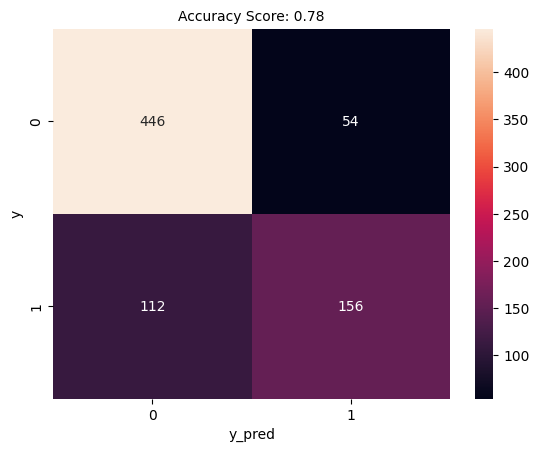

In [113]:
# şimdi karmaşıklık matrisi(Confusion Matrix) ne bir bakısh atalım
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [114]:
print(classification_report(y, y_pred)) # precision recall f1-score değerleri için veya yukarıdaki grafikten işlemi yap


              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       500
         1.0       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [115]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)
# 0.83 --> yani eğrinin altında kalan alan
# 0.8 ile 0.9 gibi değerler genelde başarılı model kurmuşsun demektir helal olsundur

np.float64(0.8394104477611941)

In [116]:
######################################################
# Model Validation: Holdout
######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# ! support sayım test ve eğitim olarak böldüğümden dolayı haliyle düştü ve hafif bir başarı oranında azalma gördümki bu normaldir
# ama her seferinde bir kontrol etmek gerekir

              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84        97
         1.0       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



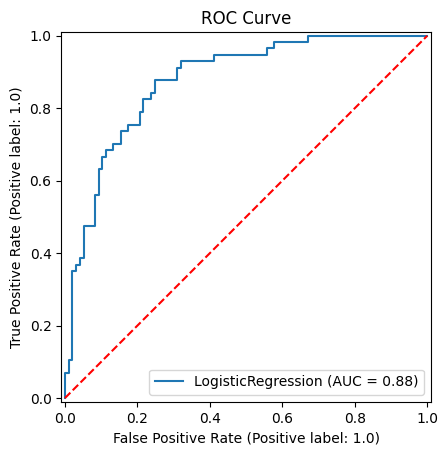

In [117]:

RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show() # bir bakış attık 
# auc değeri 88 ama öncesinde 83 tü random state değiştirirkende farklı olacak hangisi doğru bilinmez

In [118]:
# en iyisi cross validation yapmak daha tutarlı bir gözlem olur
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
# cross validation sayesinde birden fazla metriğide kısaca seçebiliyoruz


# elimizde 5 ayrı parça olduğundan ortalamasını alarak en tutarlı sonucu görüyoruz
cv_results['test_accuracy'].mean() 
# Accuracy: 0.7721

cv_results['test_precision'].mean()
# Precision: 0.7192

cv_results['test_recall'].mean()
# Recall: 0.5747

cv_results['test_f1'].mean()
# F1-score: 0.6371

cv_results['test_roc_auc'].mean()
# AUC: 0.8327
